In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from matplotlib import pyplot as plt

Preguntas de investigacion
- ¿Cómo se distribuyen las contribuciones individuales entre los diferentes candidatos?
- ¿Cuál es la relación entre el partido político de un candidato y el total de las contribuciones recibidas?
- ¿Las contribuciones financieras están correlacionadas con el éxito en las elecciones (porcentaje de votos obtenidos)?

Cargando datos

In [89]:
FinanzasCandidatos = pd.read_csv("./weball24/weball24.txt",header=None, sep='|', names=['Candidate identification','Candidate name','Incumbent challenger status','Party code','Party affiliation','Total receipts','Transfers from authorized committees','Total disbursements','Transfers to authorized committees','Beginning cash','Ending cash','Contributions from candidate','Loans from candidate','Other loans','Candidate loan repayments','Other loan repayments','Debts owed by','Total individual contributions','Candidate state','Candidate district','Special election status','Primary election status','Runoff election status','General election status','General election percentage','Contributions from other political committees','Contributions from party committees','Coverage end date','Refunds to committees','Refunds to individuals'])
Candidatos = pd.read_csv("./cn24/cn.txt", header=None, sep='|', names=["Candidate identification","Candidate name","Party affiliation","Year of election","Candidate state","Candidate office","Candidate district","Incumbent challenger status","Candidate status","Principal campaign committee","Mailing address - street","Mailing address - street2","Mailing address - city","Mailing address - state","Mailing address - ZIP code"])

Enlaces = pd.read_csv("./ccl24/ccl.txt", header=None, sep='|', names=['Candidate identification','Candidate election year','FEC election year','Committee identification','Committee type','Committee designation','Linkage ID'])

FinanzasComites = pd.read_csv("./House and Senate campañas de comites/webl24.txt", sep='|', header=None, names=["Candidate identification","Candidate name","Incumbent challenger status","Party code","Party affiliation","Total receipts","Transfers from authorized committees","Total disbursements","Transfers to authorized committees","Beginning cash","Ending cash","Contributions from candidate","Loans from candidate","Other loans","Candidate loan repayments","Other loan repayments","Debts owed by","Total individual contributions","Candidate state","Candidate district","Special election status","Primary election status","Runoff election status","General election status","General election percentage","Contributions from other political committees","Contributions from party committees","Coverage end date","Refunds to individuals","Refunds to committees"])
Comites = pd.read_csv("./Comites/cm.txt", sep= '|',header=None, names=["Committee identification","Committee name","Treasurer's name","Street one","Street two","City or town","State","ZIP code","Committee designation","Committee type","Committee party","Filing frequency","Interest group category","Connected organization's name","Candidate identification"])

In [90]:
# ContribucionesPac = pd.read_csv("./comites info/cm.txt", sep = '|', header=None, names=["Committee identification","Committee name","Committee type","Committee designation","Committee filing frequency","Total receipts","Transfers from affiliates","Contributions from individuals","Contributions from other political committees","Contributions from candidate","Candidate loans","Total loans received","Total disbursements","Transfers to affiliates","Refunds to individuals","Refunds to other political committees","Candidate loan repayments","Loan repayments","Cash beginning of period","Cash close Of period","Debts owed by","Nonfederal transfers received","Contributions to other committees","Independent expenditures","Party coordinated expenditures","Nonfederal share expenditures","Coverage end date"])
# ContribucionesIndividuales = pd.read_csv("./contribuciones individuales/by_date/itcont_2024_20240719_20260622.txt", header= None, sep='|', names=["Filer identification number","Amendment indicator","Report type","Primary-general indicator","Image number","Transaction type","Entity type","Contributor/Lender/Transfer Name","City","State","ZIP code","Employer","Occupation","Transaction date","Transaction amount","Other identification number","Transaction ID","File number / Report ID","Memo code","Memo text","FEC record number"])
# ContribucionesCandidatos = pd.read_csv("./contribuciones individuales/by_date/itcont_2024_20240719_20260622.txt", header= None, sep='|', names=["Filer identification number","Amendment indicator","Report type","Primary-general indicator","Image number","Transaction type","Entity type","Contributor/Lender/Transfer Name","City","State","ZIP code","Employer","Occupation","Transaction date","Transaction amount","Other identification number","Transaction ID","File number / Report ID","Memo code","Memo text","FEC record number"])
ContribucionesTransacciones = pd.read_csv("./transactions/itoth.txt", header= None, sep='|', names=["Filer identification number","Amendment indicator","Report type","Primary-general indicator","Image number","Transaction type","Entity type","Contributor/Lender/Transfer Name","City","State","ZIP code","Employer","Occupation","Transaction date","Transaction amount","Other identification number","Transaction ID","File number / Report ID","Memo code","Memo text","FEC record number"],
    dtype={
        "ZIP": "float64",  
        "Trans_Amount": "float64",
    },
    low_memory=False
    )


Valores duplicados

- Hint: De acuerdo a la descripción de la plataforma de Comisión Electoral Federal de Estados Unidos si existen tanto `Transfers to authorized committees` y `Transfers from authorized committees` en una misma fila, se debe descontarse de las columnas `Total disbursements` y `Total receipts` 

In [91]:
# FinanzasComites['Transfers from authorized committees'] FinanzasComites['Transfers to authorized committees'] 
duplicados = FinanzasComites[(FinanzasCandidatos['Transfers from authorized committees'] != 0) & (FinanzasComites['Transfers to authorized committees'] != 0)]
duplicados.loc[:,'Total disbursements'] = duplicados.loc[:,'Total disbursements'] - duplicados.loc[:,'Transfers from authorized committees'] - duplicados.loc[:,'Transfers to authorized committees']
duplicados.loc[:,'Total receipts'] = duplicados.loc[:,'Total receipts'] - duplicados.loc[:,'Transfers from authorized committees'] - duplicados.loc[:,'Transfers to authorized committees']
# -------------------------------------------------
FinanzasComites.loc[duplicados.index, 'Total disbursements'] = duplicados.loc[:,'Total disbursements']
FinanzasComites.loc[duplicados.index, 'Total receipts'] = duplicados.loc[:,'Total receipts']

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30296\2694205545.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  duplicados = FinanzasComites[(FinanzasCandidatos['Transfers from authorized committees'] != 0) & (FinanzasComites['Transfers to authorized committees'] != 0)]


In [92]:
duplicados = FinanzasCandidatos[(FinanzasCandidatos['Transfers from authorized committees'] != 0) & (FinanzasCandidatos['Transfers to authorized committees'] != 0)]
duplicados.loc[:,'Total disbursements'] = duplicados.loc[:,'Total disbursements'] - duplicados.loc[:,'Transfers from authorized committees'] - duplicados.loc[:,'Transfers to authorized committees']
duplicados.loc[:,'Total receipts'] = duplicados.loc[:,'Total receipts'] - duplicados.loc[:,'Transfers from authorized committees'] - duplicados.loc[:,'Transfers to authorized committees']
# -------------------------------------------------
FinanzasCandidatos.loc[duplicados.index, 'Total disbursements'] = duplicados.loc[:,'Total disbursements']
FinanzasCandidatos.loc[duplicados.index, 'Total receipts'] = duplicados.loc[:,'Total receipts']

Correjimos etiquetas

In [93]:
Candidatos['Candidate office'] = Candidatos['Candidate office'].replace({
'H':'House',
'P':'President',
'S':'Senate'
})
Candidatos['Incumbent challenger status'] = Candidatos['Candidate office'].replace({
'C':'Challenger',
'I':'Incumbent',
'O':'Open Seat'
})
Candidatos['Candidate status'] = Candidatos['Candidate status'].replace({
    'C':'Statutory candidate',
    'F':'Statutory candidate for future election',
    'N':'Not yet a statutory candidate',
    'P':'Statutory candidate in prior cycle'
})

In [94]:
Enlaces['Committee designation'] = Enlaces['Committee designation'].replace({
    'A':'Authorized by a candidate',
    'B':'Lobbyist/Registrant PAC',
    'D':'Leadership PAC',
    'J':'Joint fundraiser',
    'P':'Principal campaign committee of a candidate',
    'U':'Unauthorized'
})

In [95]:
Comites['Committee designation'] = Comites['Committee designation'].replace({
    'A':'Authorized by a candidate',
    'B':'Lobbyist/Registrant PAC',
    'D':'Leadership PAC',
    'J':'Joint fundraiser',
    'P':'Principal campaign committee of a candidate',
    'U':'Unauthorized'
})

Comites['Filing frequency'] = Comites['Filing frequency'].replace({
    'A':"Administratively terminated",
    'D':"Debt",
    'M':"Monthly filer",
    'Q':"Quarterly filer",
    'T':"Terminated",
    'W':"Waived"
})

Comites['Interest group category'] = Comites['Interest group category'].replace({
    'C':"Corporation",
    'L':"Labor organization",
    'M':"Membership organization",
    'T':"Trade association",
    'V':"Cooperative",
    'W':"Corporation without capital stock"
})



Valores nulos

In [96]:
def RevisarPorcentajeNulos(df):
    for col in df.columns:
        if df[col].isna().any():
            print("{}: {}%".format(col, round(100*df[col].isna().value_counts()[True]/df.shape[0],2)))
RevisarPorcentajeNulos(FinanzasComites)

Incumbent challenger status: 0.04%
Candidate district: 1.0%
Special election status: 100.0%
Primary election status: 100.0%
Runoff election status: 100.0%
General election status: 100.0%
General election percentage: 100.0%


In [97]:
RevisarPorcentajeNulos(Comites)

Committee name: 0.0%
Treasurer's name: 4.3%
Street one: 0.04%
Street two: 72.34%
City or town: 0.03%
State: 0.02%
ZIP code: 0.05%
Committee designation: 0.03%
Committee type: 0.02%
Committee party: 52.78%
Interest group category: 84.37%
Connected organization's name: 48.48%
Candidate identification: 60.22%


In [98]:
RevisarPorcentajeNulos(FinanzasCandidatos)

Incumbent challenger status: 0.8%
Candidate district: 0.82%
Special election status: 100.0%
Primary election status: 100.0%
Runoff election status: 100.0%
General election status: 100.0%
General election percentage: 100.0%


In [99]:
RevisarPorcentajeNulos(Candidatos)

Party affiliation: 0.21%
Candidate district: 2.62%
Candidate status: 0.02%
Principal campaign committee: 16.52%
Mailing address - street: 0.52%
Mailing address - street2: 85.53%
Mailing address - city: 0.04%
Mailing address - state: 0.33%
Mailing address - ZIP code: 0.44%


In [100]:
RevisarPorcentajeNulos(Enlaces)

Committee designation: 0.05%


In [101]:
all_rows = ContribucionesTransacciones.shape[0]

for col in ContribucionesTransacciones.columns:
    n_missing = ContribucionesTransacciones[col].isna().sum()
    
    if n_missing > 0:
        percentage_missing = round(100 * n_missing / all_rows, 2)
        print(f"{col}: {percentage_missing}%")


Primary-general indicator: 0.05%
Entity type: 0.01%
Contributor/Lender/Transfer Name: 0.0%
City: 0.01%
State: 0.01%
ZIP code: 0.01%
Employer: 10.4%
Occupation: 10.28%
Transaction date: 0.04%
Other identification number: 89.8%
Transaction ID: 0.0%
Memo code: 10.0%
Memo text: 61.62%


Retiramos columnas con 100% de valores nulos

In [102]:
# Eliminar columnas con datos faltantes al 100% o mayormente vacías
FinanzasComites = FinanzasComites.drop(columns=['Special election status', 'Primary election status', 'Runoff election status', 'General election status', 'General election percentage'])
Comites = Comites.drop(columns=['Street two', 'Interest group category'])
FinanzasCandidatos = FinanzasCandidatos.drop(columns=['Special election status', 'Primary election status', 'Runoff election status', 'General election status', 'General election percentage'])
ContribucionesTransacciones = ContribucionesTransacciones.drop(columns=['Other identification number'])


Imputamos valores por moda, en base a ser preferencias del público basadas en mayoria y el valor de las transacciones con la media.

In [103]:
FinanzasComites['Incumbent challenger status'].fillna(FinanzasComites['Incumbent challenger status'].mode()[0], inplace=True)
Comites['Treasurer\'s name'].fillna(Comites['Treasurer\'s name'].mode()[0], inplace=True)
Candidatos['Party affiliation'].fillna(Candidatos['Party affiliation'].mode()[0], inplace=True)
ContribucionesTransacciones['Entity type'].fillna(ContribucionesTransacciones['Entity type'].mode()[0], inplace=True)
Comites['ZIP code'].fillna(Comites['ZIP code'].mode()[0], inplace=True)
ContribucionesTransacciones['ZIP code'].fillna(ContribucionesTransacciones['ZIP code'].mode()[0], inplace=True)


# Imputación de variables numéricas con la media
ContribucionesTransacciones['Transaction amount'].fillna(ContribucionesTransacciones['Transaction amount'].mean(), inplace=True)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30296\1296460422.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  FinanzasComites['Incumbent challenger status'].fillna(FinanzasComites['Incumbent challenger status'].mode()[0], inplace=True)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30296\1296460422.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the interm

Verificamos

In [104]:
print("FinanzasComites__________")
RevisarPorcentajeNulos(FinanzasComites)
print("Comites_________________")
RevisarPorcentajeNulos(Comites)
print("FinanzasCandidatos_______")
RevisarPorcentajeNulos(FinanzasCandidatos)
print("Candidatos_______________")
RevisarPorcentajeNulos(Candidatos)
print("Enlaces__________________")
RevisarPorcentajeNulos(Enlaces)

FinanzasComites__________
Candidate district: 1.0%
Comites_________________
Committee name: 0.0%
Street one: 0.04%
City or town: 0.03%
State: 0.02%
Committee designation: 0.03%
Committee type: 0.02%
Committee party: 52.78%
Connected organization's name: 48.48%
Candidate identification: 60.22%
FinanzasCandidatos_______
Incumbent challenger status: 0.8%
Candidate district: 0.82%
Candidatos_______________
Candidate district: 2.62%
Candidate status: 0.02%
Principal campaign committee: 16.52%
Mailing address - street: 0.52%
Mailing address - street2: 85.53%
Mailing address - city: 0.04%
Mailing address - state: 0.33%
Mailing address - ZIP code: 0.44%
Enlaces__________________
Committee designation: 0.05%


In [105]:
ContribucionesTransacciones['Report type'] = ContribucionesTransacciones['Report type'].replace({
    "12C":	"Pre-convention",
    "12G":	"Pre-general",
    "12P":	"Pre-primary",
    "12R":	"Pre-Runoff",
    "12S":	"Pre-special",
    "30D":	"Post-Election",
    "30G":	"Post-general",
    "30P":	"Post-primary",
    "30R":	"Post-runoff",
    "30S":	"Post-special",
    "60D":	"Post-convention",
    "ADJ":	"Comprehensive adjusted amendment",
    "CA":	"Comprehensive amendment	Amendment",
    "M10":	"October monthly	Covers",
    "M11":	"November monthly",
    "M12":	"December monthly",
    "M2":	"February monthly",
    "M3":	"March monthly",
    "M4":	"April monthly",
    "M5":	"May monthly	Covers April",
    "M6":	"June monthly",
    "M7":	"July monthly",
    "M8":	"August monthly",
    "M9":	"September monthly",
    "MY":	"Mid-year",
    "Q1":	"April quarterly",
    "Q2":	"July quarterly",
    "Q3":	"October quarterly",
    "TER":	"Termination Final",
    "YE":	"Year end",
    "90S":	"Post inaugural",
    "90D":	"Post inaugural",
    "48H":	"48-hour",
    "24H":	"24-hour"
})

In [106]:
Comitestest = Comites.copy()

Para imputar cambiamos las categorías con un Encoder

In [107]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical(df, columns):
    le = LabelEncoder()
    label_mappings = {}
    for col in columns:
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            df[col] = df[col].fillna('Unknown')  
            df[col] = le.fit_transform(df[col].astype(str))
            label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    

    return df, label_mappings

FinanzasCandidatos, labelsFinanzasCandidatos = encode_categorical(FinanzasCandidatos, ['Candidate district', 'Incumbent challenger status'])
Comites, lablesComites = encode_categorical(Comites, ['Committee name', 'Street one', 'City or town', 'State', 'Committee designation', 'Committee type', 'Committee party', 'Connected organization\'s name', 'Candidate identification'])
FinanzasComites, labelsFinanzasComites = encode_categorical(FinanzasComites, ['Candidate district'])
Candidatos, labelsCandidatos = encode_categorical(Candidatos, ['Candidate district', 'Candidate status', 'Principal campaign committee', 'Mailing address - street', 'Mailing address - city', 'Mailing address - state'])


Imputamos los valores restantes con KNN imputation

In [108]:
from sklearn.impute import KNNImputer

columns_to_impute_comites = ['State', 'City or town', 'Committee designation', 'Committee type', 'Committee party', 'Connected organization\'s name', 'Candidate identification']
columns_to_impute_finanzascomites = ['Candidate district']
columns_to_impute_finanzascandidatos = ['Candidate district', 'Incumbent challenger status']
columns_to_impute_candidatos = ['Candidate district', 'Principal campaign committee', 'Mailing address - street', 'Mailing address - city', 'Mailing address - state']

def knn_imputation(df, columns):
    imputer = KNNImputer(n_neighbors=5)
    df[columns] = imputer.fit_transform(df[columns])
    return df

Comites = knn_imputation(Comites, columns_to_impute_comites)
FinanzasComites = knn_imputation(FinanzasComites, columns_to_impute_finanzascomites)
FinanzasCandidatos = knn_imputation(FinanzasCandidatos, columns_to_impute_finanzascandidatos)
Candidatos = knn_imputation(Candidatos, columns_to_impute_candidatos)


Re etiquetamos

In [109]:
taggIncumbent = {}
for key, value in labelsFinanzasCandidatos['Incumbent challenger status'].items():
    taggIncumbent[value] = key
FinanzasCandidatos['Incumbent challenger status'] = FinanzasCandidatos['Incumbent challenger status'].astype(int)
FinanzasCandidatos['Incumbent challenger status'] = FinanzasCandidatos['Incumbent challenger status'].apply(lambda x: taggIncumbent[x])

taggIncumbent2 = {
    'C': 'Challenger',
    'I': 'Incumbent',
    'O': 'Open Seat',
    'Unknown' : 'Unknown'
}
FinanzasCandidatos['Incumbent challenger status'] = FinanzasCandidatos['Incumbent challenger status'].apply(lambda x: taggIncumbent2[x])


In [110]:
taggCandidateStatus = {}
for key, value in labelsCandidatos['Candidate status'].items():
    taggCandidateStatus[value] = key
Candidatos['Candidate status'] = Candidatos['Candidate status'].astype(int)
Candidatos['Candidate status'] = Candidatos['Candidate status'].apply(lambda x: taggCandidateStatus[x])

In [182]:
taggCandidateId = {}
for key, value in lablesComites['Candidate identification'].items():
    taggCandidateId[value] = key
Comites['Candidate identification'] = Comites['Candidate identification'].astype(int)
Comites['Candidate identification'] = Comites['Candidate identification'].apply(lambda x: taggCandidateId[x])

Verificamos

In [111]:
# Verificar si quedan valores nulos después de la imputación
print(Comites[columns_to_impute_comites].isnull().sum())
print(FinanzasComites[columns_to_impute_finanzascomites].isnull().sum())
print(FinanzasCandidatos[columns_to_impute_finanzascandidatos].isnull().sum())
print(Candidatos[columns_to_impute_candidatos].isnull().sum())


State                            0
City or town                     0
Committee designation            0
Committee type                   0
Committee party                  0
Connected organization's name    0
Candidate identification         0
dtype: int64
Candidate district    0
dtype: int64
Candidate district             0
Incumbent challenger status    0
dtype: int64
Candidate district              0
Principal campaign committee    0
Mailing address - street        0
Mailing address - city          0
Mailing address - state         0
dtype: int64


Visualizacion

1. Conteo de comités por candidato

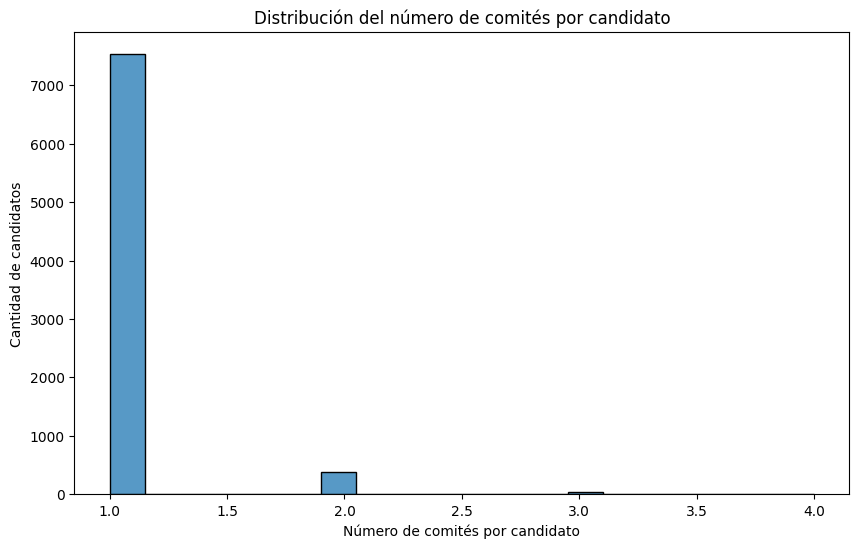

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Contar el número de comités por candidato usando la tabla "Enlaces"
comites_por_candidato = Enlaces.groupby('Candidate identification')['Committee identification'].nunique()

# Visualización del conteo
plt.figure(figsize=(10, 6))
sns.histplot(comites_por_candidato, kde=False, bins=20)
plt.title('Distribución del número de comités por candidato')
plt.xlabel('Número de comités por candidato')
plt.ylabel('Cantidad de candidatos')
plt.show()


2. Relación entre tipo de comité y candidato  
Re etiquetamos los códigos del tipo de comites

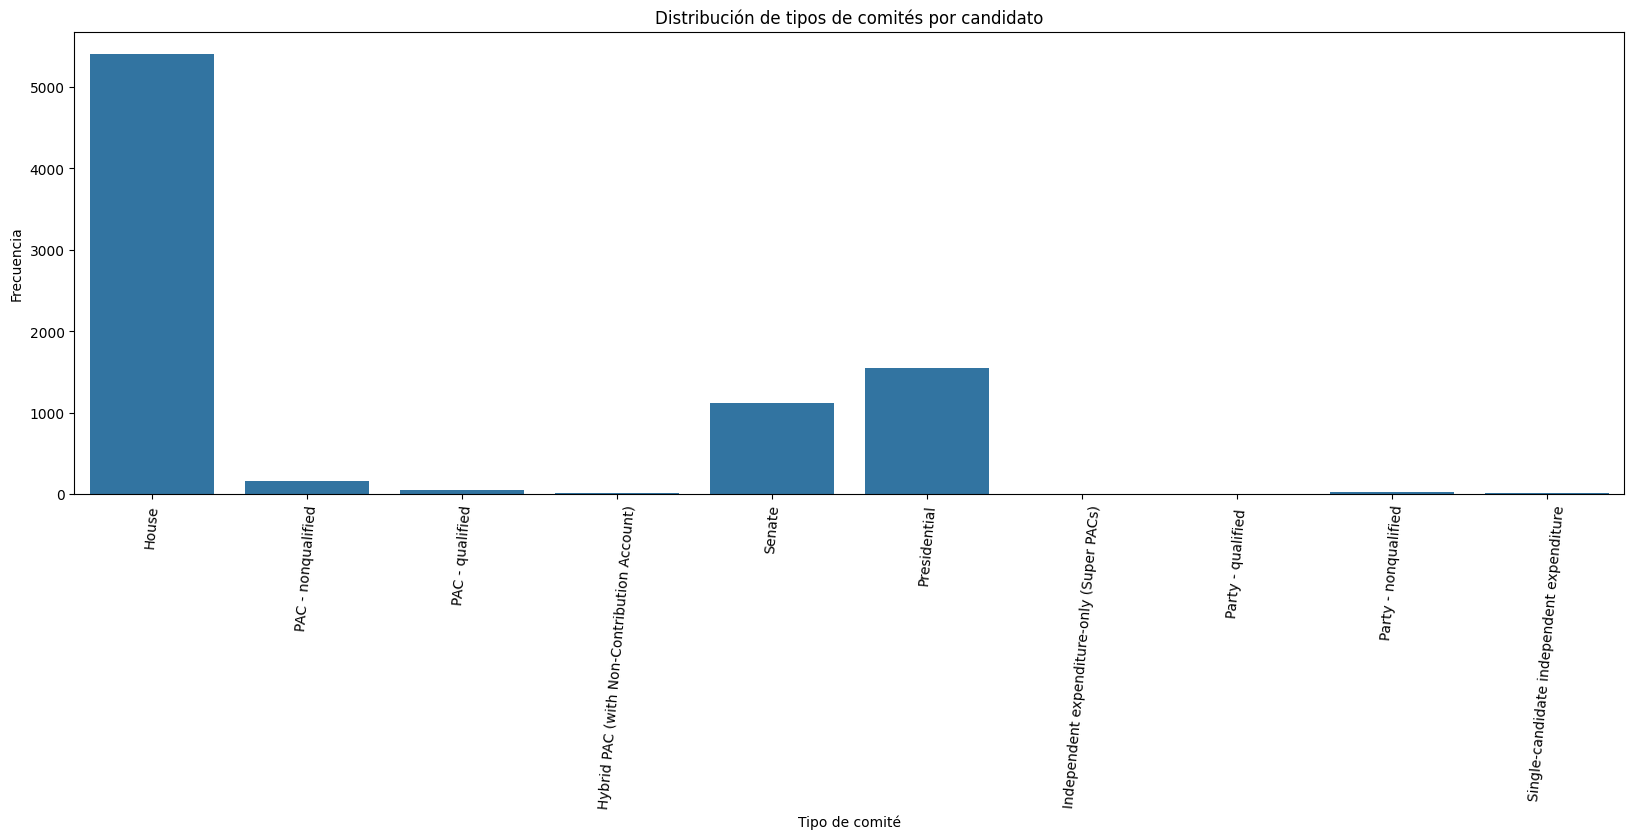

In [113]:
comites_candidatos = Enlaces.merge(Comites, on='Committee identification')


comites_candidatos['Committee type_x'] = comites_candidatos['Committee type_x'].replace({
    'C':"Communication cost",
    'D':"Delegate committee",
    'E':"Electioneering communication",
    'H':"House",
    'I':"Independent expenditor (person or group)",
    'N':"PAC - nonqualified",
    'O':"Independent expenditure-only (Super PACs)",
    'P':"Presidential",
    'Q':"PAC - qualified",
    'S':"Senate",
    'V':"Hybrid PAC (with Non-Contribution Account)",
    'W':"Hybrid PAC (with Non-Contribution Account)",
    'X':"Party - nonqualified",
    'Y':"Party - qualified ",
    'Z':"National party nonfederal account",
    'U':"Single-candidate independent expenditure"
})



plt.figure(figsize=(20, 6))
sns.countplot(x='Committee type_x', data=comites_candidatos)
plt.title('Distribución de tipos de comités por candidato')
plt.xlabel('Tipo de comité')
plt.ylabel('Frecuencia')
plt.xticks(rotation=85)
plt.show()


3. Comparación de ingresos totales

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30296\1012655231.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finanzas_candidatos['Incumbent challenger status'] = finanzas_candidatos['Incumbent challenger status'].replace({


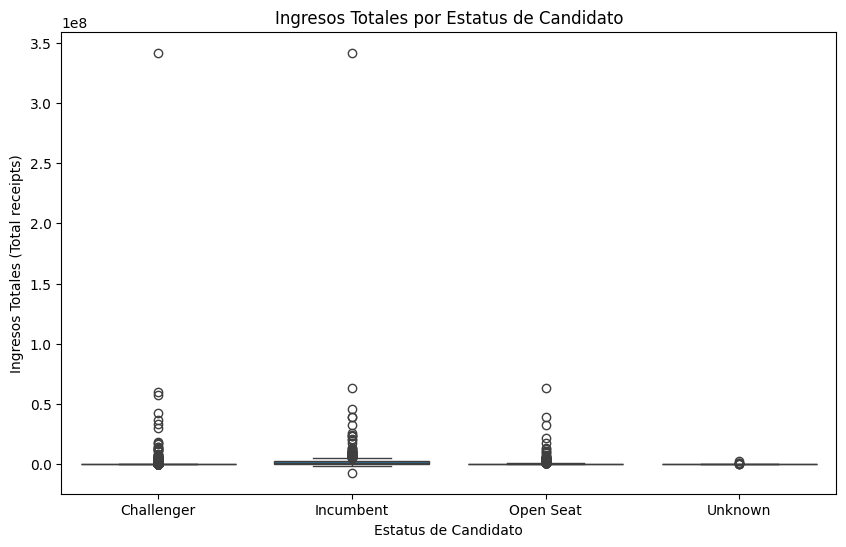

In [114]:
finanzas_candidatos = FinanzasCandidatos[['Candidate name', 'Incumbent challenger status', 'Total receipts', 'Total disbursements']]

finanzas_candidatos['Incumbent challenger status'] = finanzas_candidatos['Incumbent challenger status'].replace({
    0:"Challenger",
    1:"Incumbent",
    2:"Open Seat(no re-election)",
    3:"Unknown"
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Incumbent challenger status', y='Total receipts', data=finanzas_candidatos)
plt.title('Ingresos Totales por Estatus de Candidato')
plt.xlabel('Estatus de Candidato')
plt.ylabel('Ingresos Totales (Total receipts)')
plt.show()

Revisando los outliers, hay valores demasiado altso así como valores negativos

In [115]:
status_type = ["Challenger","Incumbent","Open Seat(no re-election)","Unknown"]
outliers = pd.DataFrame({}, columns=['Candidate name', 'Incumbent challenger status', 'Total receipts','Total disbursements'])
for status in status_type:
    finanzas_candidatosStatus = finanzas_candidatos[finanzas_candidatos['Incumbent challenger status'] == status] 
    outliers = pd.concat([outliers, finanzas_candidatosStatus[finanzas_candidatosStatus['Total receipts'] == finanzas_candidatosStatus['Total receipts'].max()]], axis=0)
outliers

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30296\244367652.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  outliers = pd.concat([outliers, finanzas_candidatosStatus[finanzas_candidatosStatus['Total receipts'] == finanzas_candidatosStatus['Total receipts'].max()]], axis=0)


,Candidate name,Incumbent challenger status,Total receipts,Total disbursements
3013,"HARRIS, KAMALA",Challenger,3.416975e+08,1.080715e+08
3035,"BIDEN, JOSEPH R JR",Incumbent,3.417460e+08,1.080502e+08
3478,"NICKEL, WILEY",Unknown,2.274867e+06,1.575650e+06


In [116]:
outliersNegativos = finanzas_candidatos[(finanzas_candidatos['Total receipts'] < 0) | (finanzas_candidatos['Total receipts'] < 0)]
outliersNegativos

,Candidate name,Incumbent challenger status,Total receipts,Total disbursements
52,"HENDREN, JAMES PAUL",Challenger,-63.80,0.00
446,"PORTER, KATHERINE",Incumbent,-7085665.06,349293.80
561,"KIRKMEYER, BARBARA",Open Seat,-148.89,31703.85
601,"BLUNT ROCHESTER, LISA",Incumbent,-91984.24,489389.41
763,"BUONGIORNO, JEFFREY D",Challenger,-185240.76,93570.90
838,"WEST, CHRISTOPHER CHRIS",Challenger,-31.74,20808.22
1045,"DEERING, REGAN",Challenger,-111.79,4545.16
1068,"KING, ESTHER JOY",Open Seat,-64.35,78993.64
1377,"GIBBS, JOHN",Challenger,-220.50,1067.24
1396,"SLOTKIN, ELISSA",Incumbent,-207626.55,-79206.72


Podemos formularnos diferentes razones:
1. Errores de reporte:
Errores en los datos: Es posible que haya errores en la forma en que los datos han sido ingresados o reportados al sistema. Las campañas a veces cometen errores al reportar cantidades o al clasificar las transacciones, estos son errores en la agregació, por ejemplo si los datos se están procesando o agregando incorrectamente, podría generarse un valor negativo accidentalmente.
2. Reembolsos:
Reembolsos de contribuciones: En algunos casos, los candidatos deben devolver contribuciones a individuos o comités por razones legales o políticas. Si los reembolsos superan las contribuciones recibidas en un período de reporte, los ingresos podrían aparecer como negativos. Otra forma sería la devolución de fondos a comités, si una campaña transfiere o reembolsa fondos a comités o individuos, esto podría reducir temporalmente los ingresos netos.
3. Ajustes contables:
Correcciones de informes anteriores: Si un candidato o comité descubre que ha reportado incorrectamente ingresos en informes anteriores, pueden realizar ajustes que reduzcan los ingresos reportados. En algunos casos, esto podría resultar en un valor negativo si los ingresos informados en informes previos fueron sobrestimados.
4. Préstamos cancelados:
La condonación de deudas sucede cuando un candidato perdona o cancela una deuda significativa que previamente se reportaba como ingreso (por ejemplo, un préstamo del propio candidato), esto podría generar un ajuste negativo.

Al final estas personas debería ser indagadas por la FCA, y asegurar la integridad del proceso electoral

Volvemos a graficar sin los outliers:

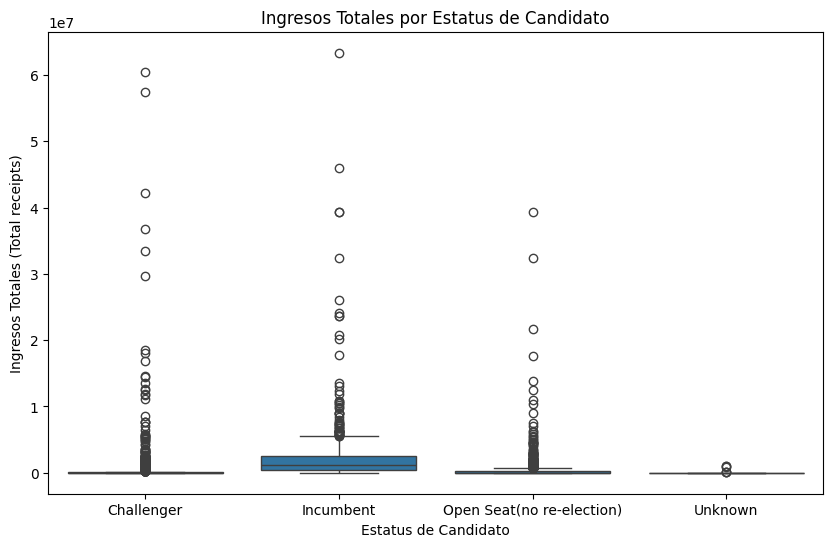

In [28]:
# finanzas_candidatos = FinanzasCandidatos[['Candidate name', 'Incumbent challenger status', 'Total receipts', 'Total disbursements']]
finanzas_candidatos_sin_outliers = finanzas_candidatos.drop(outliers.index)
finanzas_candidatos_sin_outliers = finanzas_candidatos_sin_outliers.drop(outliersNegativos.index)


plt.figure(figsize=(10, 6))
sns.boxplot(x='Incumbent challenger status', y='Total receipts', data=finanzas_candidatos_sin_outliers)
plt.title('Ingresos Totales por Estatus de Candidato')
plt.xlabel('Estatus de Candidato')
plt.ylabel('Ingresos Totales (Total receipts)')
plt.show()

Unificamos las finanzas y la informacion de los candidatos

In [117]:
FinanzasCandidatosAdicional = Candidatos.merge(FinanzasCandidatos, how='right', on='Candidate identification')
FinanzasCandidatosAdicional = FinanzasCandidatosAdicional.loc[:, ~FinanzasCandidatosAdicional.columns.str.endswith('_y')]
FinanzasCandidatosAdicional.columns = FinanzasCandidatosAdicional.columns.str.replace('_x', '')
FinanzasCandidatosAdicional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3764 entries, 0 to 3763
Data columns (total 34 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Candidate identification                       3764 non-null   object 
 1   Candidate name                                 3760 non-null   object 
 2   Party affiliation                              3760 non-null   object 
 3   Year of election                               3760 non-null   float64
 4   Candidate state                                3760 non-null   object 
 5   Candidate office                               3760 non-null   object 
 6   Candidate district                             3760 non-null   float64
 7   Incumbent challenger status                    3760 non-null   object 
 8   Candidate status                               3760 non-null   object 
 9   Principal campaign committee                   3760 

Encontramos nulos

In [135]:
FinanzasCandidatosAdicional[FinanzasCandidatosAdicional['Candidate name'].isnull()]

,Candidate identification,Candidate name,Party affiliation,Year of election,Candidate state,Candidate office,Candidate district,Incumbent challenger status,Candidate status,Principal campaign committee,...,Other loans,Candidate loan repayments,Other loan repayments,Debts owed by,Total individual contributions,Contributions from other political committees,Contributions from party committees,Coverage end date,Refunds to committees,Refunds to individuals
118,H4AZ07142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,300504.0,0.0,0.0,06/30/2024,195.0,0.0
1343,H4MD06274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,07/04/2023,0.0,0.0
3167,P40010522,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,03/31/2023,0.0,0.0
3170,P40015703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,07/14/2024,0.0,0.0


Como no tenemos informacion retiraremos las filas

In [136]:
FinanzasCandidatosAdicional = FinanzasCandidatosAdicional.drop(FinanzasCandidatosAdicional[FinanzasCandidatosAdicional['Candidate name'].isnull()].index)

4. Distribución de 'Total receipts'

<Axes: xlabel='Total receipts', ylabel='Count'>

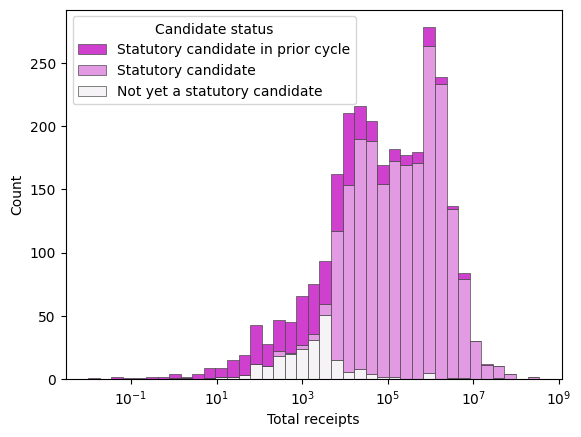

In [143]:
sns.histplot(
    FinanzasCandidatosAdicional,
    x="Total receipts", hue="Candidate status",
    multiple="stack",
    palette="light:m_r",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)

5. Correlación entre características numéricas y 'Total receipts' 

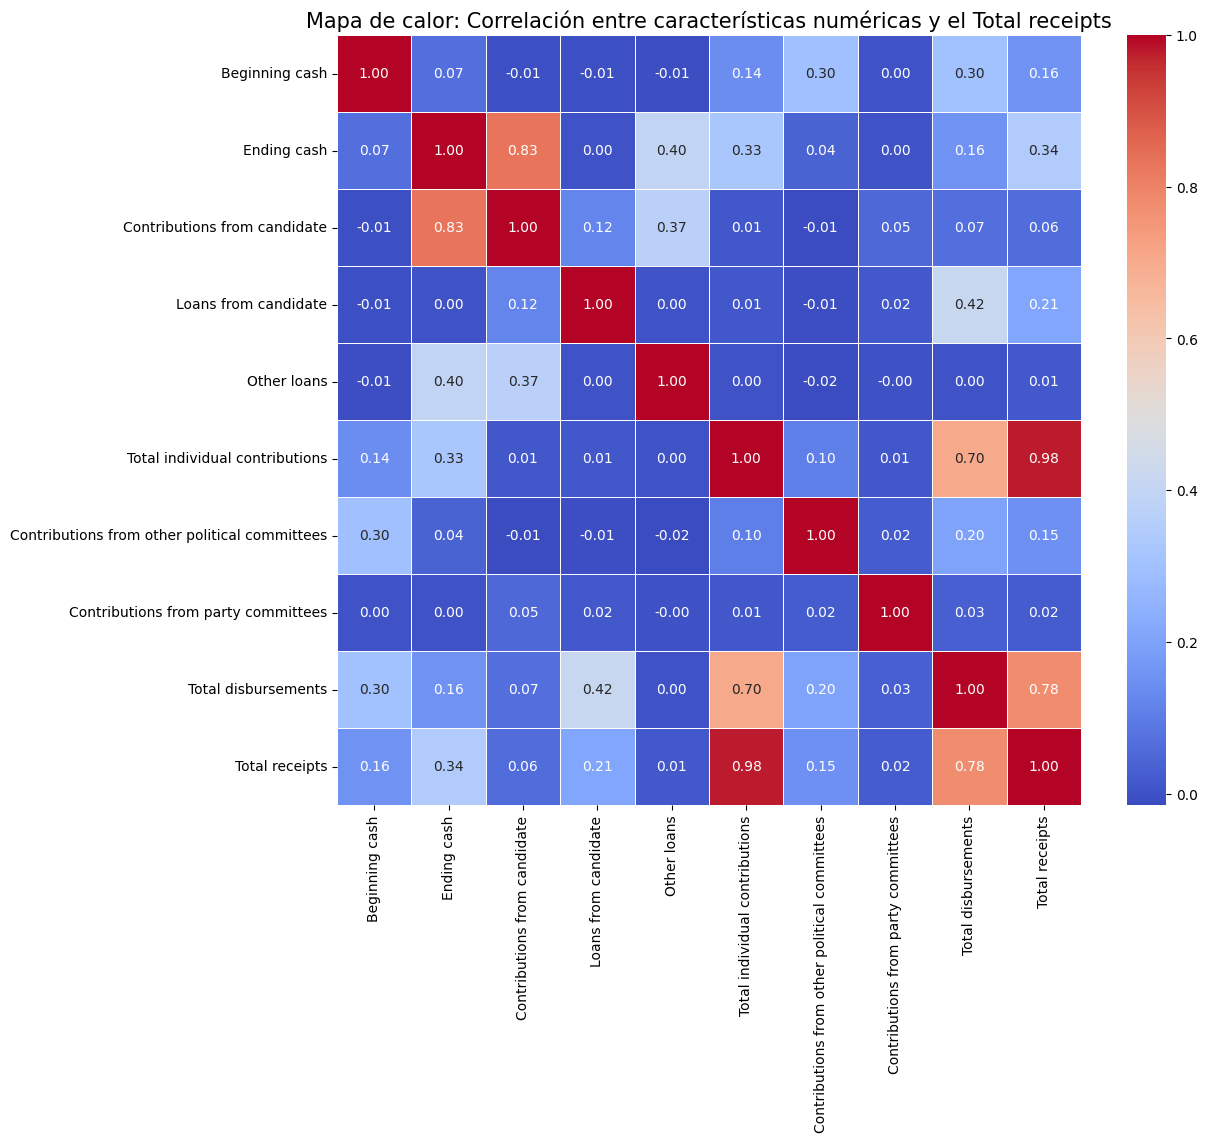

In [145]:
# Visualización de la correlación entre características numéricas y 'Total receipts'
plt.figure(figsize=(12, 10))
numerical_columns = ['Beginning cash', 'Ending cash', 'Contributions from candidate', 'Loans from candidate', 
                     'Other loans', 'Total individual contributions', 'Contributions from other political committees', 
                     'Contributions from party committees', 'Total disbursements', 'Total receipts']
correlation_matrix = FinanzasCandidatosAdicional[numerical_columns].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Mapa de calor: Correlación entre características numéricas y el Total receipts', fontsize=15)
plt.show()

6. Relación entre el 'Party affiliation' y 'Total receipts'

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30296\966181574.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Party affiliation', y='Total receipts', data=FinanzasCandidatosAdicional, palette='Set3',log_scale=True)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\s

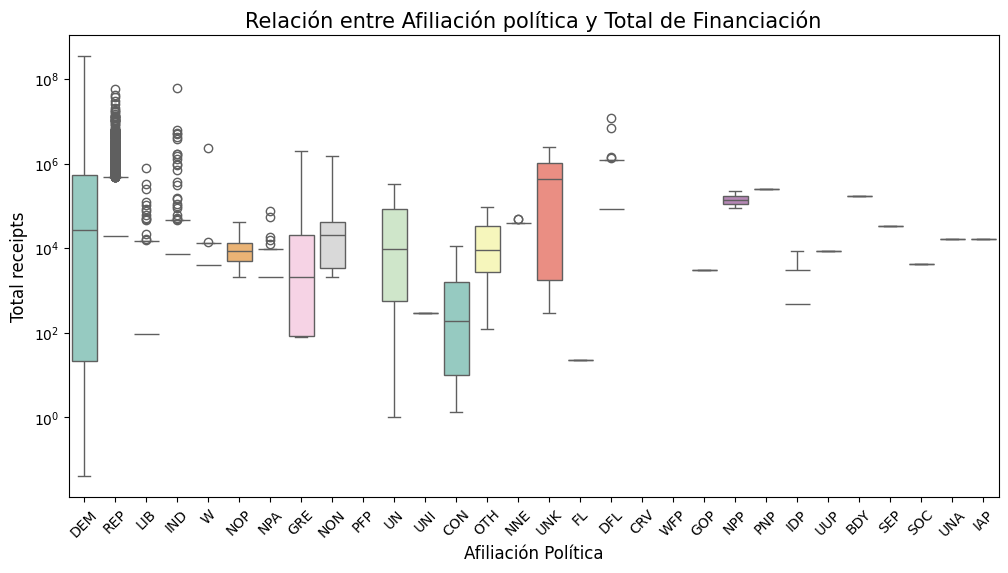

In [150]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Party affiliation', y='Total receipts', data=FinanzasCandidatosAdicional, palette='Set3',log_scale=True)
plt.title('Relación entre Afiliación política y Total de Financiación', fontsize=15)
plt.xlabel('Afiliación Política', fontsize=12)
plt.ylabel('Total receipts', fontsize=12)
plt.xticks(rotation=45)
plt.show()

6. Análisis 'Incumbent challenger status' vs 'Total receipts'

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_30296\2808158040.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Incumbent challenger status', y='Total receipts', data=FinanzasCandidatosAdicional, palette='Set3',log_scale=True)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a *

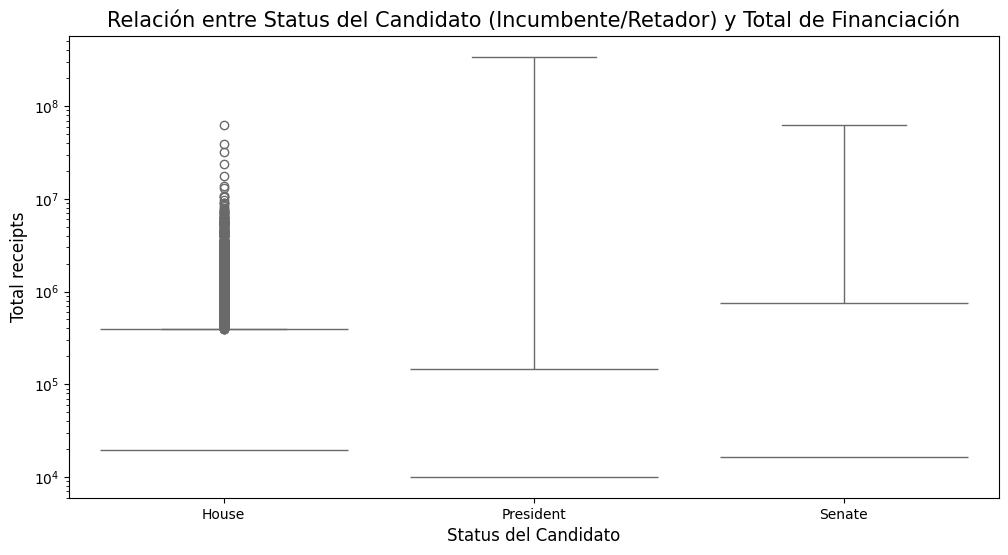

In [154]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Incumbent challenger status', y='Total receipts', data=FinanzasCandidatosAdicional, palette='Set3',log_scale=True)
plt.title('Relación entre Status del Candidato (Incumbente/Retador) y Total de Financiación', fontsize=15)
plt.xlabel('Status del Candidato', fontsize=12)
plt.ylabel('Total receipts', fontsize=12)
plt.show()

7. 'Total individual contributions' vs 'Total receipts'

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


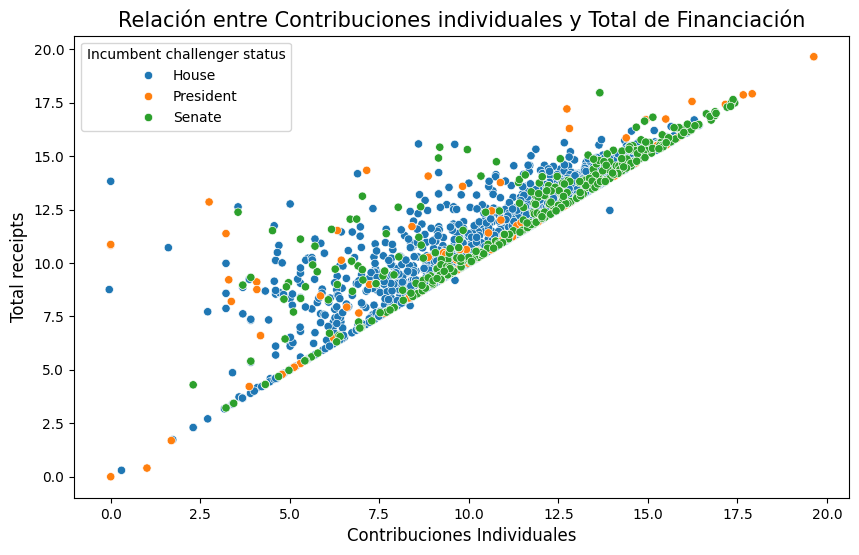

In [161]:
plt.figure(figsize=(10, 6))
yTotal_receipts = np.log(FinanzasCandidatosAdicional['Total receipts'])
xTotal_individual_contributions = np.log(FinanzasCandidatosAdicional['Total individual contributions'])
sns.scatterplot(x=xTotal_individual_contributions, y=yTotal_receipts, hue='Incumbent challenger status',data=FinanzasCandidatosAdicional, color='green')
plt.title('Relación entre Contribuciones individuales y Total de Financiación', fontsize=15)
plt.xlabel('Contribuciones Individuales', fontsize=12)
plt.ylabel('Total receipts', fontsize=12)
plt.show()


8. Scatterplot para 'Ending cash' vs 'Total receipts'

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


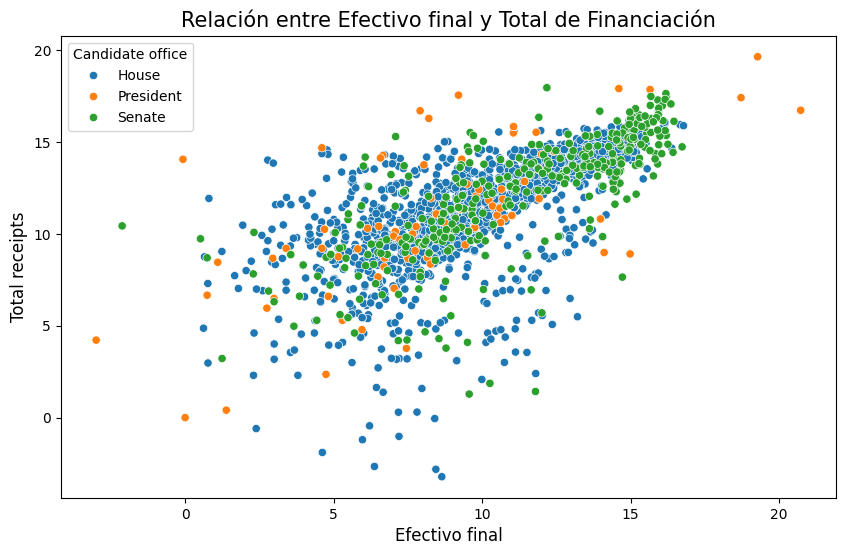

In [173]:
plt.figure(figsize=(10, 6))
xEnding_cash = np.log(FinanzasCandidatosAdicional['Ending cash'])

sns.scatterplot(x=xEnding_cash, y=yTotal_receipts, data=FinanzasCandidatosAdicional, color='orange', hue='Candidate office')
plt.title('Relación entre Efectivo final y Total de Financiación', fontsize=15)
plt.xlabel('Efectivo final', fontsize=12)
plt.ylabel('Total receipts', fontsize=12)
plt.show()

Integracion

In [184]:
import pandas as pd

df_merged = pd.merge(FinanzasComites, FinanzasCandidatos, on='Candidate identification', how='left')
df_merged = pd.merge(df_merged, Comites, on='Candidate identification', how='left')
df_merged = pd.merge(df_merged, ContribucionesTransacciones, left_on='Committee identification', right_on='Filer identification number', how='left')

df_merged = df_merged.loc[:, ~df_merged.columns.str.endswith('_y')]
df_merged.columns = df_merged.columns.str.replace('_x', '')
df_merged.head()


,Candidate identification,Candidate name,Incumbent challenger status,Party code,Party affiliation,Total receipts,Transfers from authorized committees,Total disbursements,Transfers to authorized committees,Beginning cash,...,City,Employer,Occupation,Transaction date,Transaction amount,Transaction ID,File number / Report ID,Memo code,Memo text,FEC record number
0,H2AK01158,"PELTOLA, MARY",I,1,DEM,7541673.55,178500.0,5396920.4,0.0,691260.3,...,LOS ANGELES,NaN,NaN,5152024.0,1800.0,6985068,1800618.0,X,* PELTOLA VICTORY FUND,4.071720e+18
1,H2AK01158,"PELTOLA, MARY",I,1,DEM,7541673.55,178500.0,5396920.4,0.0,691260.3,...,NEW YORK,LUPA SYSTEMS LLC,CEO/FOUNDER,11022023.0,3300.0,6282248,1752674.0,X,* DEMOCRATIC FUTURE LEADERSHIP FUND,4.020120e+18
2,H2AK01158,"PELTOLA, MARY",I,1,DEM,7541673.55,178500.0,5396920.4,0.0,691260.3,...,NEW YORK,QUADRIVUM FOUNDATION,CEO,11022023.0,3300.0,6282229,1752674.0,X,* DEMOCRATIC FUTURE LEADERSHIP FUND,4.020120e+18
3,H2AK01158,"PELTOLA, MARY",I,1,DEM,7541673.55,178500.0,5396920.4,0.0,691260.3,...,NEW YORK,QUADRIVUM FOUNDATION,CEO,11022023.0,3300.0,6282249,1752674.0,X,* DEMOCRATIC FUTURE LEADERSHIP FUND,4.020120e+18
4,H2AK01158,"PELTOLA, MARY",I,1,DEM,7541673.55,178500.0,5396920.4,0.0,691260.3,...,ATHERTON,MEDLEY PARTNERS,INVESTOR,8012023.0,3300.0,6282224,1752674.0,X,* DEMOCRATIC FUTURE LEADERSHIP FUND,4.020120e+18


In [2]:
# df_merged.to_csv("Financiamiento.csv", index=False)
df_merged = pd.read_csv("Financiamiento.csv", low_memory=False)

Identificamos columnas relevantes

In [3]:
relevant_columns = [
    'Total receipts',                    # Variable objetivo: Total de financiación
    'Candidate state',                   # Estado del candidato
    'Candidate district',                # Distrito del candidato
    'Incumbent challenger status',       # Status del candidato (Incumbente o retador)
    'Party affiliation',                 # Afiliación política del candidato
    'Contributions from candidate',      # Contribuciones del propio candidato
    'Loans from candidate',              # Préstamos del propio candidato
    'Contributions from other political committees',  # Contribuciones de otros comités
    'Contributions from party committees',  # Contribuciones del partido
    'Beginning cash',                    # Dinero al inicio de la campaña
    'Ending cash',                       # Dinero al final de la campaña
    'Debts owed by',                     # Deudas de la campaña
    'Refunds to committees',             # Reembolsos a comités
    'Refunds to individuals',            # Reembolsos a individuos
    'Total individual contributions',    # Contribuciones individuales
]

Train = df_merged[relevant_columns]
Train.info()
del df_merged

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6933415 entries, 0 to 6933414
Data columns (total 15 columns):
 #   Column                                         Dtype  
---  ------                                         -----  
 0   Total receipts                                 float64
 1   Candidate state                                object 
 2   Candidate district                             float64
 3   Incumbent challenger status                    object 
 4   Party affiliation                              object 
 5   Contributions from candidate                   float64
 6   Loans from candidate                           float64
 7   Contributions from other political committees  float64
 8   Contributions from party committees            float64
 9   Beginning cash                                 float64
 10  Ending cash                                    float64
 11  Debts owed by                                  float64
 12  Refunds to committees                     

In [4]:
print(Train.isnull().sum())

Total receipts                                   0
Candidate state                                  0
Candidate district                               0
Incumbent challenger status                      0
Party affiliation                                0
Contributions from candidate                     0
Loans from candidate                             0
Contributions from other political committees    0
Contributions from party committees              0
Beginning cash                                   0
Ending cash                                      0
Debts owed by                                    0
Refunds to committees                            0
Refunds to individuals                           0
Total individual contributions                   0
dtype: int64


Preprocesamos (Candidate district ya esta transformado)

Normalizamos

In [5]:
numerical_cols = ['Total receipts',
       'Contributions from candidate', 'Loans from candidate',
       'Contributions from other political committees',
       'Contributions from party committees', 'Beginning cash', 'Ending cash',
       'Debts owed by', 'Refunds to committees', 'Refunds to individuals',
       'Total individual contributions']

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

numerical_columns = Train[numerical_cols].select_dtypes(include=['float64', 'int64']).columns

df_normalized = Train[numerical_cols].copy()
df_normalized[numerical_columns] = scaler.fit_transform(Train[numerical_columns])

print("Datos normalizados:")
print(df_normalized.head())


Datos normalizados:
   Total receipts  Contributions from candidate  Loans from candidate  \
0        0.011254                           0.0                   0.0   
1        0.011254                           0.0                   0.0   
2        0.011254                           0.0                   0.0   
3        0.011254                           0.0                   0.0   
4        0.011254                           0.0                   0.0   

   Contributions from other political committees  \
0                                       0.400951   
1                                       0.400951   
2                                       0.400951   
3                                       0.400951   
4                                       0.400951   

   Contributions from party committees  Beginning cash  Ending cash  \
0                             0.001007        0.035017     0.003544   
1                             0.001007        0.035017     0.003544   
2              

Realizamos encoding a las columnas Candidate state, Incumbent challenger status y Party affiliation

In [7]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical(df, columns):
    le = LabelEncoder()
    label_mappings = {}
    for col in columns:
        if df[col].dtype == 'object' or df[col].dtype.name == 'category':
            df[col] = df[col].fillna('Unknown')  
            df[col] = le.fit_transform(df[col].astype(str))
            label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
    

    return df, label_mappings

Train_Categorical, labelTrain = encode_categorical(Train, ['Candidate state', 'Incumbent challenger status','Party affiliation'])


Unificamos

In [8]:
Train_cols = [
       'Contributions from candidate', 'Loans from candidate',
       'Contributions from other political committees',
       'Contributions from party committees', 'Beginning cash', 'Ending cash',
       'Debts owed by', 'Refunds to committees', 'Refunds to individuals',
       'Total individual contributions']

In [9]:
X = pd.concat([df_normalized[Train_cols], Train['Candidate district'], Train_Categorical], axis=1)
y = df_normalized['Total receipts']


Modelamiento y predicciones del total de financiación

In [20]:
print(X.dtypes)

Contributions from candidate                     float64
Loans from candidate                             float64
Contributions from other political committees    float64
Contributions from party committees              float64
Beginning cash                                   float64
Ending cash                                      float64
Debts owed by                                    float64
Refunds to committees                            float64
Refunds to individuals                           float64
Total individual contributions                   float64
Candidate district                               float64
Total receipts                                   float64
Candidate state                                    int32
Candidate district                               float64
Incumbent challenger status                        int32
Party affiliation                                  int32
Contributions from candidate                     float64
Loans from candidate           

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

model = RandomForestRegressor(n_estimators = 10, random_state = 30)
model.fit(X_train, y_train)

prediction_test = model.predict(X_test)
#print(y_test, prediction_test)

In [22]:
from sklearn import metrics
import pandas as pd

print("Mean Absolute Error (MAE):", metrics.mean_absolute_error(y_test, prediction_test))
print("Mean Squared Error (MSE):", metrics.mean_squared_error(y_test, prediction_test))
print("Root Mean Squared Error (RMSE):", metrics.mean_squared_error(y_test, prediction_test, squared=False))
print("R² Score:", metrics.r2_score(y_test, prediction_test))

feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_, index=feature_list).sort_values(ascending=False)
print(feature_imp)


Mean Absolute Error (MAE): 7.842221402562235e-10
Mean Squared Error (MSE): 5.143353065253131e-13
Root Mean Squared Error (RMSE): 7.171717413042103e-07
R² Score: 0.9999999999852104
Total receipts                                   8.962555e-01
Ending cash                                      9.937613e-02
Refunds to individuals                           2.186226e-03
Total individual contributions                   7.267404e-04
Refunds to individuals                           7.264725e-04
Total individual contributions                   7.261141e-04
Contributions from party committees              8.272310e-07
Contributions from party committees              8.193450e-07
Refunds to committees                            3.164985e-07
Candidate state                                  2.977679e-07
Beginning cash                                   1.952844e-07
Refunds to committees                            1.543046e-07
Incumbent challenger status                      1.284072e-07
Beginning cash

c:\Users\LENOVO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
